In [1]:
import numpy as np
import dask
import xarray as xr
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#cluster = PBSCluster(cores=28, processes=4, walltime='12:00:00')
w = cluster.scale(14*1)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [6]:
client

Client Scheduler: tcp://10.148.1.87:34451 Dashboard: http://10.148.1.87:8787/status,Cluster Workers: 7 Cores: 7 Memory: 119.98 GB


# Figures
_________________

# 1. KE and PI

In [4]:
## KE of 1-5 days and > 5 days 
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/'
ds_KE = xr.open_zarr(out_dir_zarr+'KE_mean.zarr')
ds_KE

<xarray.Dataset>
Dimensions:                   (depth: 40, time: 8761)
Coordinates:
  * depth                     (depth) float64 0.5 1.57 2.79 ... 473.3 506.5
  * time                      (time) datetime64[ns] 2011-09-13 ... 2012-09-12
Data variables:
    KE_bandpass_filter_smean  (time, depth) float32 dask.array<chunksize=(8761, 1), meta=np.ndarray>
    KE_low_filter_smean       (time, depth) float32 dask.array<chunksize=(8761, 1), meta=np.ndarray>

In [5]:
# Coarse-grained PI (spatial average and cumulative integral)
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/cg_butter/'
PI_cg = xr.open_zarr(out_dir_store+'PI_cg_butter_all.zarr')

out_dir = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')
ds_MLD
ds = xr.merge([PI_cg,ds_MLD])
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))
ds = ds.assign_coords(time=time_day) 
ds.persist()
ds

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Dimensions without coordinates: lat, lon
Data variables:
    PI_cg_cumsum  (depth, time) float32 dask.array<chunksize=(1, 9415), meta=np.ndarray>
    PI_cg_smean   (depth, time) float32 dask.array<chunksize=(1, 9415), meta=np.ndarray>
    mld_filter    (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>

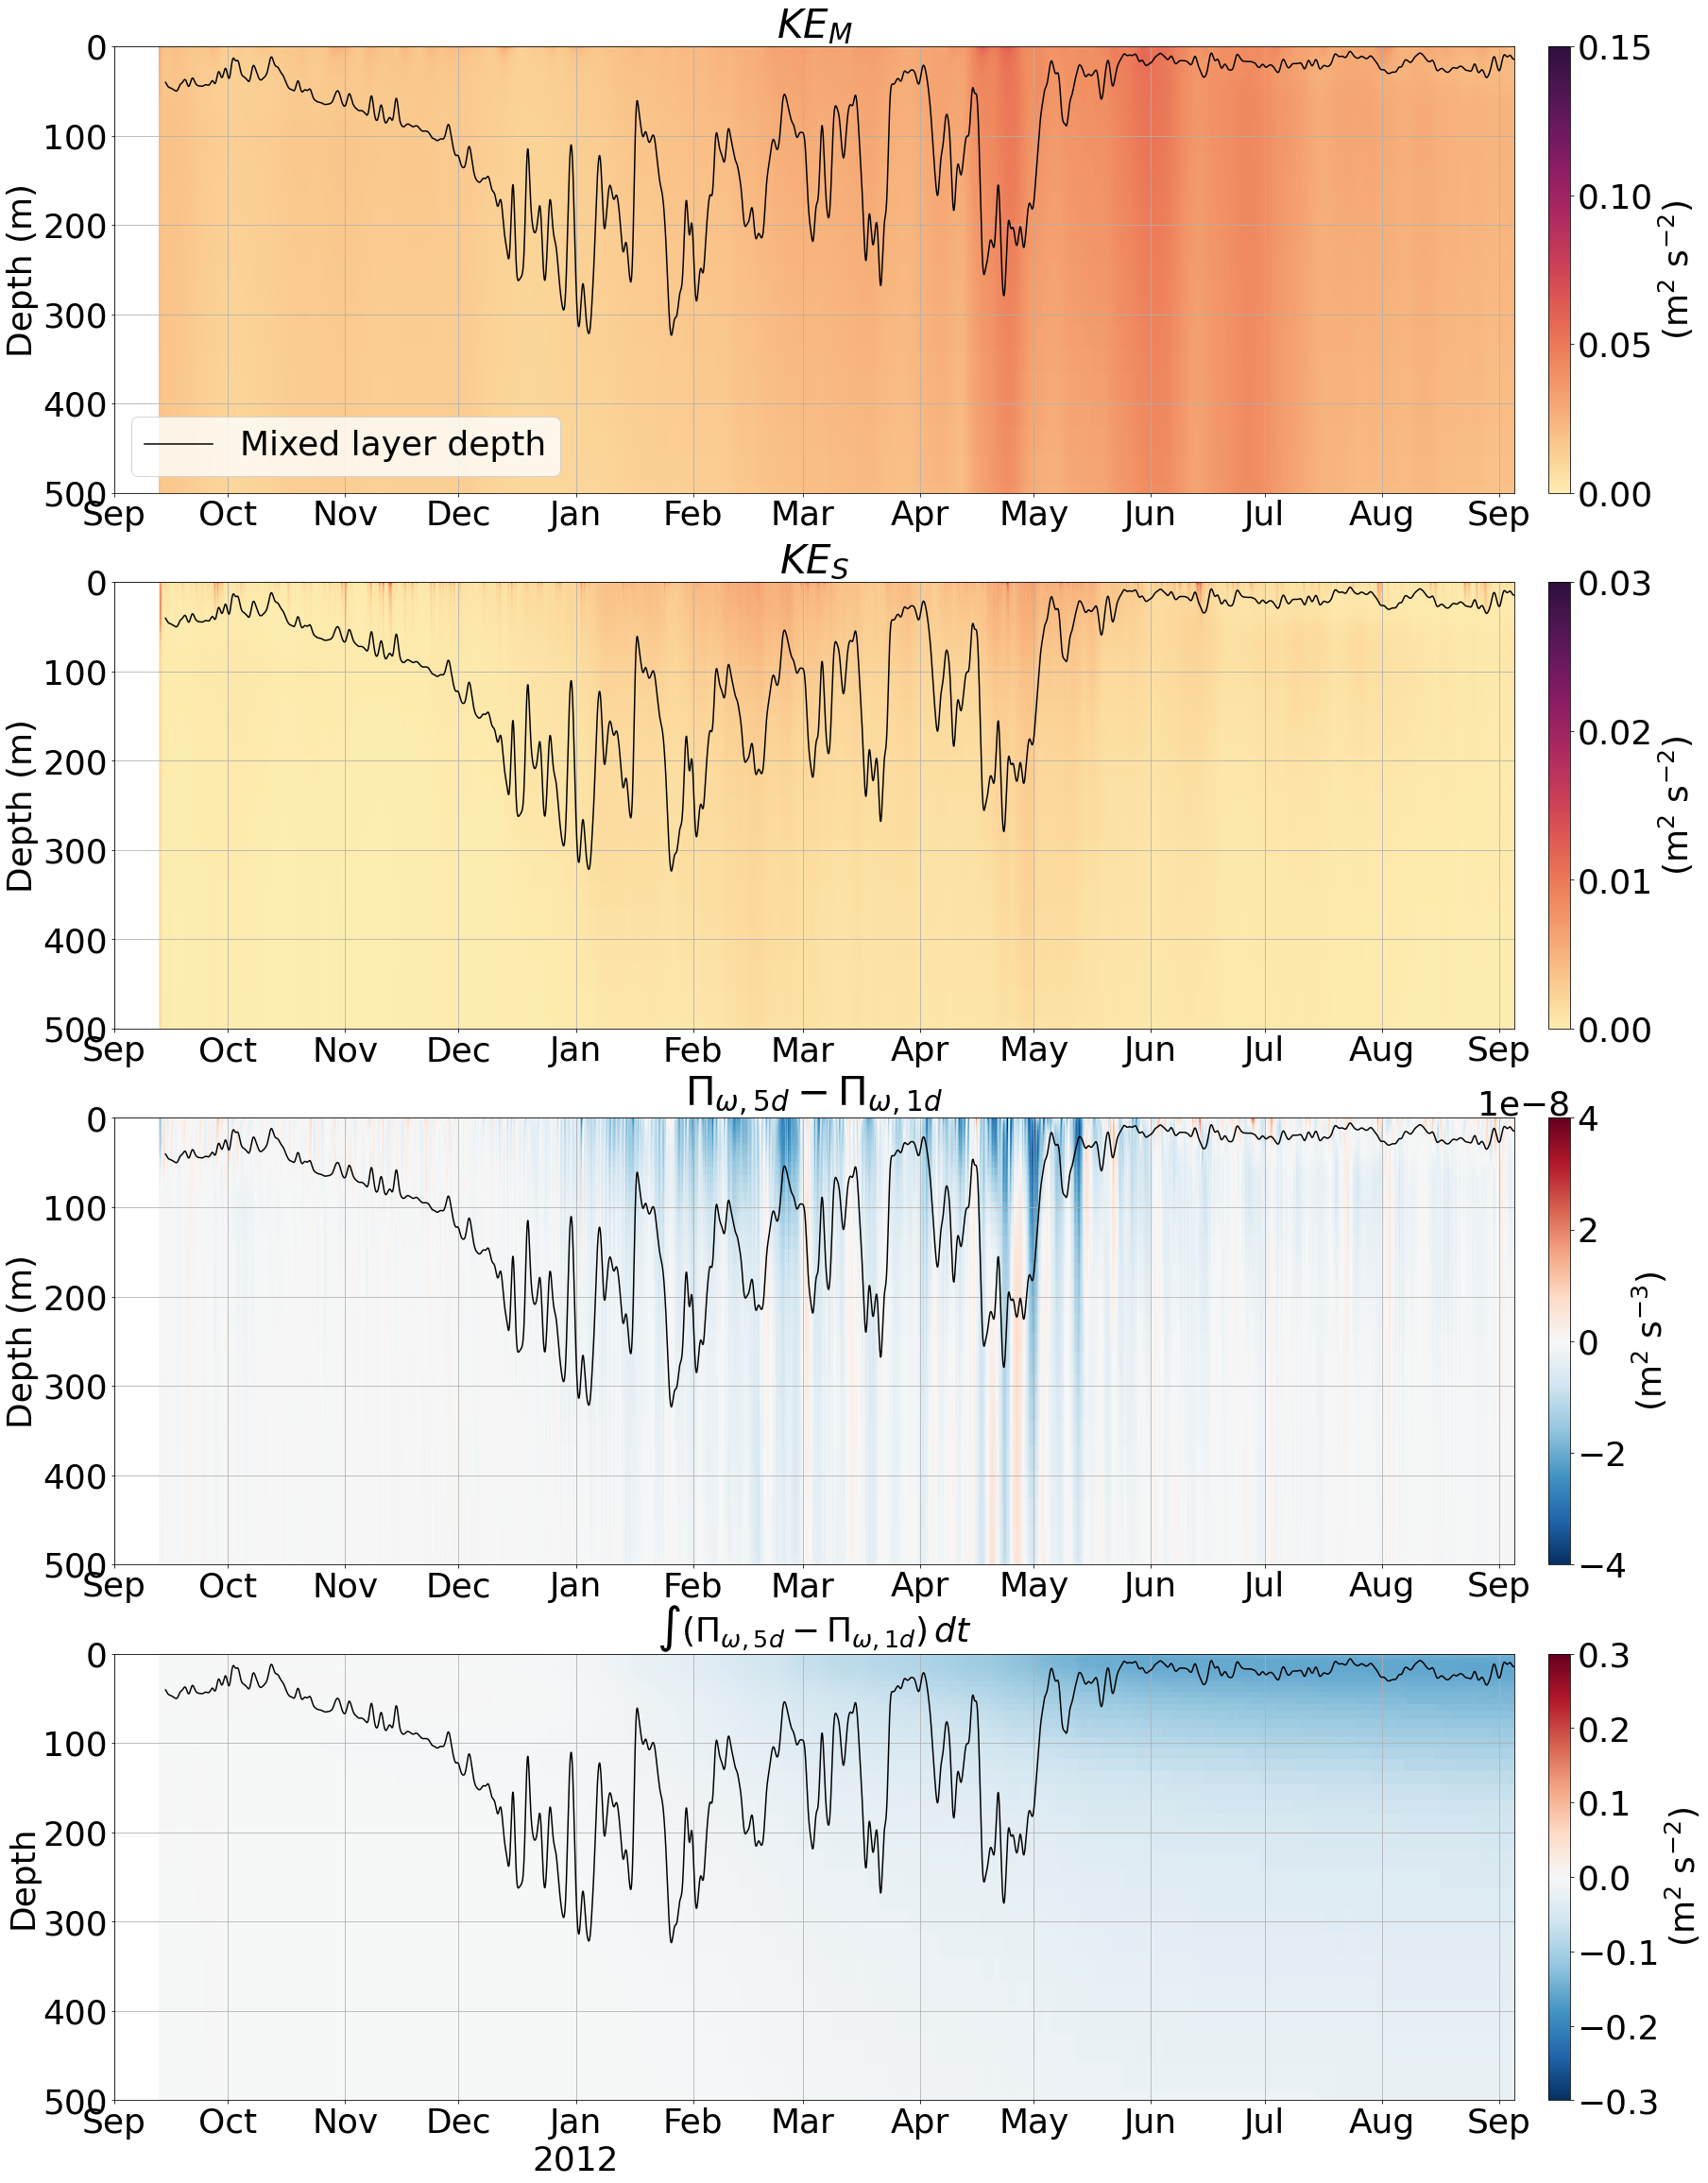

In [9]:
plt.rc('font', size=36) 
font_size = 36
font_title = 42
labels = ['Mixed layer depth']

fig = plt.figure(figsize=(32,40))
ax = plt.subplot(411)
cax=(ds_KE.KE_low_filter_smean).plot(x='time', y='depth', vmin=0, vmax=0.15, cmap=cm.matter, add_colorbar = False, yincrease=False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.05, 0.10, 0.15], pad=0.02)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ds.mld_filter.isel(time=slice(0,8761)).mean(['lat','lon']).plot(x='time',yincrease=False, color='black', label=labels[0])
ax.grid()
ax.legend(); 
ax.legend(prop={'size': font_size})
ax.set_title('$KE_M$',fontsize=font_title)
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], ha='center')
plt.xticks(rotation=0)

ax = plt.subplot(412)
cax=(ds_KE.KE_bandpass_filter_smean).plot(x='time', y='depth', vmin=0, vmax=0.03, cmap=cm.matter, add_colorbar = False, yincrease=False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.01, 0.02, 0.03], pad=0.02)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ds.mld_filter.isel(time=slice(0,8761)).mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.grid()
ax.set_title('$KE_S$',fontsize=font_title)
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], ha='center')
plt.xticks(rotation=0)

ax = plt.subplot(413)
cax= ds.PI_cg_smean.plot(x='time', y='depth',vmin=-4e-8,vmax=4e-8,cmap='RdBu_r', yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-4e-8, -2e-8, 0, 2e-8, 4e-8], pad=0.02)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-3}$)', fontsize=font_size)
ds.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.grid()
ax.set_title('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$',fontsize=font_title)
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], ha='center')
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
plt.xticks(rotation=0)

ax = plt.subplot(414)
cax = ds.PI_cg_cumsum.plot(x='time', y='depth',cmap='RdBu_r',vmin=-0.3,vmax=0.3,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-0.3,-0.2, -0.1, 0, 0.1, 0.2, 0.3], pad=0.02)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.grid()
ax.set_title('$\int(\Pi_{\omega,5d}-\Pi_{\omega,1d})\,dt$',fontsize=font_title)
ax.set_ylim([1000., 0.])
ds.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('Time',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
#ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan (2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan\n2012', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], ha='center')
plt.xticks(rotation=0)
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.set_title('$\int(\Pi_{\omega,5d}-\Pi_{\omega,1d})\,dt$',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/OSMOSIS/Diagnostics/Figures/KE.png')

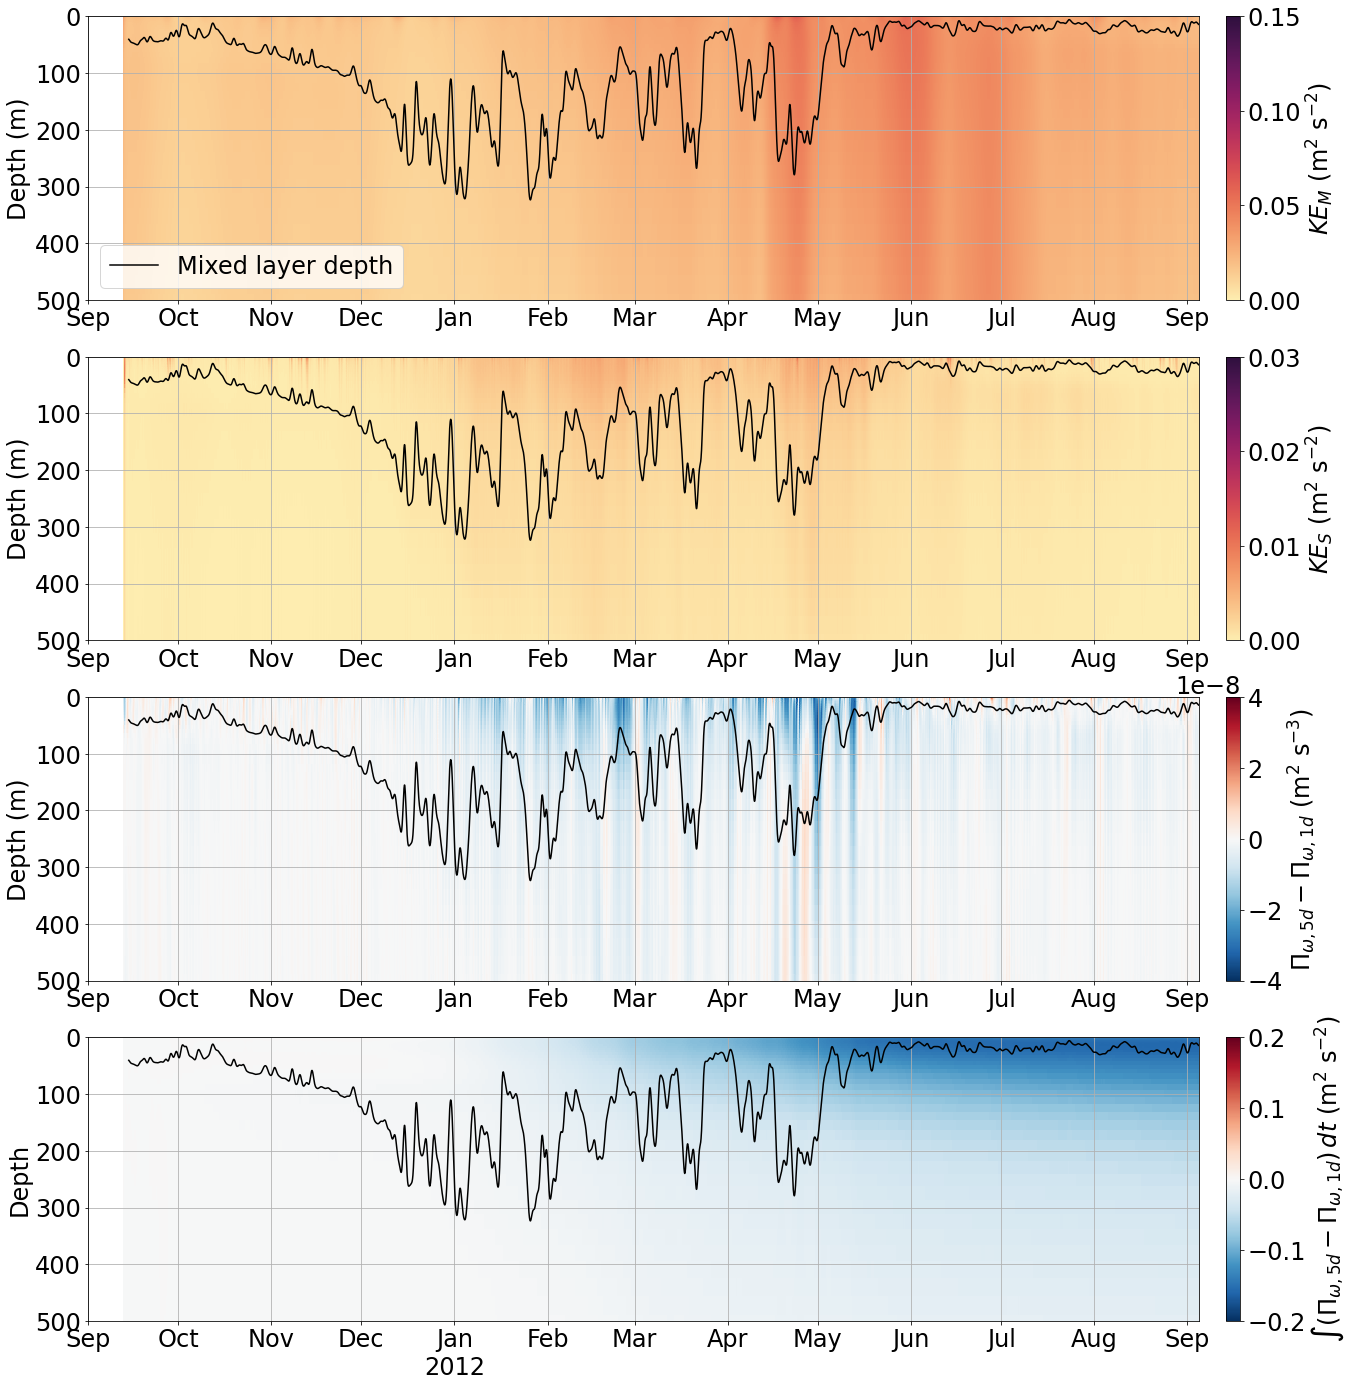

In [10]:
plt.rc('font', size=24) 
font_size = 24
labels = ['Mixed layer depth']

fig = plt.figure(figsize=(24,24))
ax = plt.subplot(411)
cax=(ds_KE.KE_low_filter_smean).plot(x='time', y='depth', vmin=0, vmax=0.15, cmap=cm.matter, add_colorbar = False, yincrease=False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.05, 0.10, 0.15], pad=0.02)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$KE_M$ (m$^2$ s$^{-2}$)', fontsize=font_size)
ds.mld_filter.isel(time=slice(0,8761)).mean(['lat','lon']).plot(x='time',yincrease=False, color='black', label=labels[0])
ax.grid()
ax.legend(); 
ax.legend(prop={'size': 24})
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], ha='center')
plt.xticks(rotation=0)

ax = plt.subplot(412)
cax=(ds_KE.KE_bandpass_filter_smean).plot(x='time', y='depth', vmin=0, vmax=0.03, cmap=cm.matter, add_colorbar = False, yincrease=False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.01, 0.02, 0.03], pad=0.02)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$KE_S$ (m$^2$ s$^{-2}$)', fontsize=font_size)
ds.mld_filter.isel(time=slice(0,8761)).mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.grid()
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], ha='center')
plt.xticks(rotation=0)

ax = plt.subplot(413)
cax= ds.PI_cg_smean.plot(x='time', y='depth',vmin=-4e-8,vmax=4e-8,cmap='RdBu_r', yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-4e-8, -2e-8, 0, 2e-8, 4e-8], pad=0.02)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)', fontsize=font_size)
ds.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], ha='center')
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
plt.xticks(rotation=0)

ax = plt.subplot(414)
cax = ds.PI_cg_cumsum.plot(x='time', y='depth',cmap='RdBu_r',vmin=-0.2,vmax=0.2,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-0.2, -0.1, 0, 0.1, 0.2], pad=0.02)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\int(\Pi_{\omega,5d}-\Pi_{\omega,1d})\,dt$ (m$^2$ s$^{-2}$)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('Time',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
#ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan (2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan\n2012', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], ha='center')
plt.xticks(rotation=0)
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/OSMOSIS/Diagnostics/Figures/KE.png')

__________________
# 2. PI Seasons

In [12]:
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/cg_butter/'
PI_cg_butter = xr.open_zarr(out_dir_store+'PI_cg_butter.zarr')

out_dir = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

ds = xr.merge([PI_cg_butter,ds_MLD])
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
ds

<xarray.Dataset>
Dimensions:     (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    PI_cg       (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    mld_filter  (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>

In [13]:
winter = ds.PI_cg.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(16,39)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00')).mean(['depth','time'])
spring = ds.PI_cg.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(16,39)).sel(time=slice('2011-03-01T00:00:00','2012-06-01T00:00:00')).mean(['depth','time'])

winter.load()
spring.load()

<xarray.DataArray 'PI_cg' (lat: 197, lon: 173)>
array([[-1.4460385e-08, -1.5343579e-08, -1.7757655e-08, ...,
        -1.0792743e-09, -5.0094551e-10,  6.9001138e-11],
       [-1.5217624e-08, -1.5711999e-08, -1.7348752e-08, ...,
         3.7058977e-11,  1.0847049e-09,  1.3286651e-09],
       [-1.4702061e-08, -1.6098983e-08, -1.7060014e-08, ...,
         1.4194903e-09,  1.7854507e-09,  1.4757072e-09],
       ...,
       [ 9.3093866e-10,  6.8082906e-10,  5.9744304e-10, ...,
         1.3056402e-09,  3.6239517e-10,  1.5251639e-10],
       [-1.4477251e-09, -2.0884006e-09, -2.0212199e-09, ...,
         1.3415091e-10, -4.2103063e-10, -1.1206751e-09],
       [-3.8793613e-09, -4.1483936e-09, -3.5271628e-09, ...,
        -1.0783222e-09, -2.2394115e-09, -3.2948198e-09]], dtype=float32)
Coordinates:
  * lat      (lat) float64 47.43 47.44 47.46 47.47 ... 49.92 49.94 49.95 49.96
  * lon      (lon) float64 -17.99 -17.97 -17.95 -17.93 ... -14.45 -14.43 -14.41

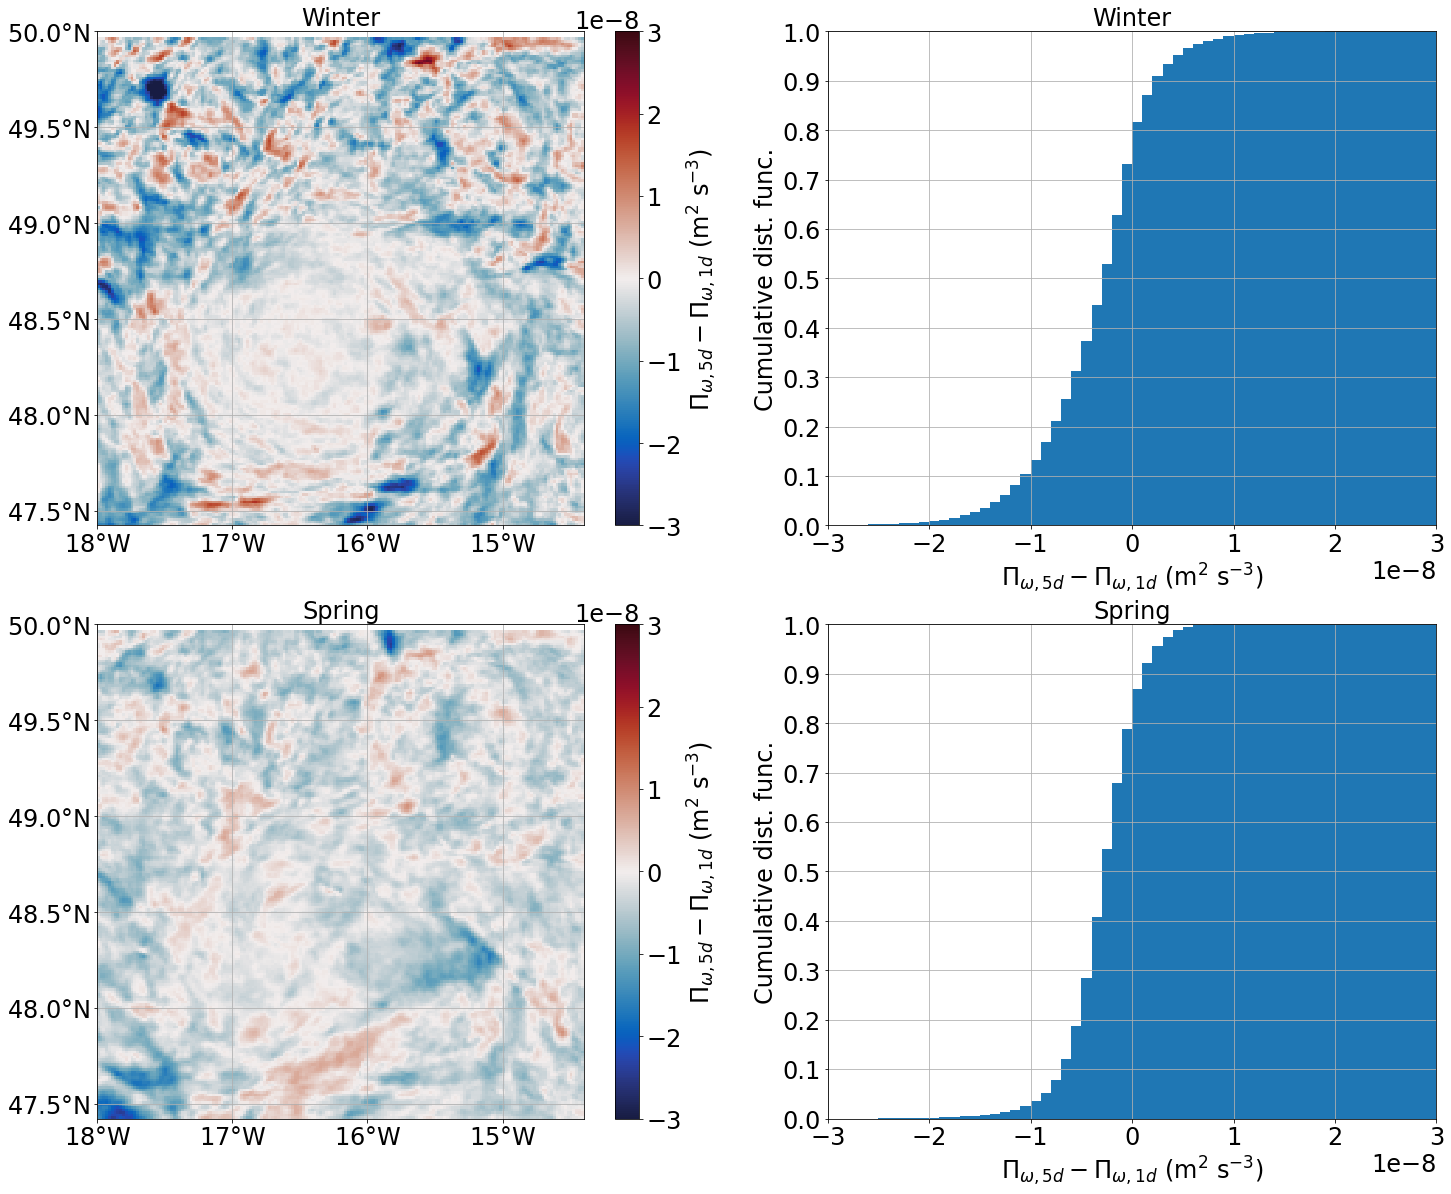

In [14]:
plt.rc('font', size=24) 
font_size=24

fig, ax = plt.subplots(figsize=(24,20))
ax = plt.subplot(221)
cax = winter.plot(x='lon', y='lat',cmap=cm.balance, vmin=-3e-8,vmax=3e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-3e-8, -2e-8, -1e-8, 0, 1e-8, 2e-8, 3e-8])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.set_xticks([-18,-17,-16,-15])
ax.set_xticklabels(['$18\degree$W','$17\degree$W','$16\degree$W','$15\degree$W'], ha='center')
ax.set_yticks([47.5,48.0,48.5,49.0,49.5,50])
ax.set_yticklabels(['$47.5\degree$N','$48.0\degree$N','$48.5\degree$N','$49.0\degree$N','$49.5\degree$N','$50.0\degree$N'])
ax.set_title('Winter',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(223)
cax = spring.plot(x='lon', y='lat',cmap=cm.balance, vmin=-3e-8,vmax=3e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-3e-8, -2e-8, -1e-8, 0, 1e-8, 2e-8, 3e-8])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.set_xticks([-18,-17,-16,-15])
ax.set_xticklabels(['$18\degree$W','$17\degree$W','$16\degree$W','$15\degree$W'], ha='center')
ax.set_yticks([47.5,48.0,48.5,49.0,49.5,50])
ax.set_yticklabels(['$47.5\degree$N','$48.0\degree$N','$48.5\degree$N','$49.0\degree$N','$49.5\degree$N','$50.0\degree$N'])
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
winter.plot.hist(bins=np.arange(-4e-8,4e-8,1e-9),density=True,cumulative=True)
ax.grid()
ax.set_xlim([-3e-8,3e-8])
ax.set_ylim([0.,1])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_title('Winter',fontsize=font_size)
ax.set_ylabel('Cumulative dist. func.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(224)
spring.plot.hist(bins=np.arange(-4e-8,4e-8,1e-9),density=True,cumulative=True)
ax.grid()
ax.set_xlim([-3e-8,3e-8])
ax.set_ylim([0.,1])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_ylabel('Cumulative dist. func.',fontsize=font_size)
#ax.set_xlabel('$\Pi_{\omega}$ (m$^2$ s$^{-3}$)',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/OSMOSIS/Diagnostics/Figures/Pi_cg_winter_spring.png')

In [13]:
winter_inverse = winter.where(winter<0).count(dim=['lat','lon'])
winter_inverse

<xarray.DataArray 'PI_cg' ()>
array(24910)

In [14]:
spring_inverse = spring.where(spring<0).count(dim=['lat','lon'])
spring_inverse

<xarray.DataArray 'PI_cg' ()>
array(26876)

In [28]:
winter_total = winter.count(dim=['lat','lon'])
winter_total

<xarray.DataArray 'PI_cg' ()>
array(34081)

In [26]:
24910/34081

0.730905783281007

In [27]:
26876/34081

0.7885918840409613

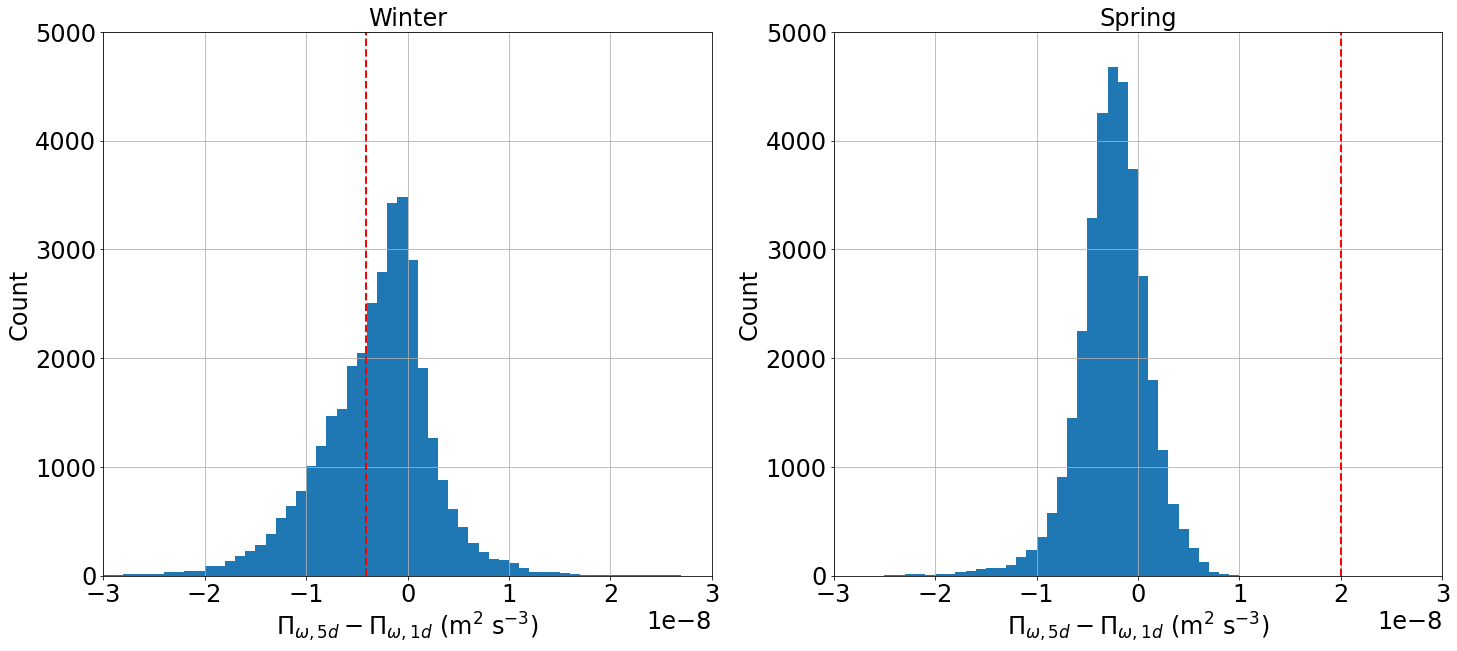

In [15]:
plt.rc('font', size=24) 
font_size=24

fig, ax = plt.subplots(figsize=(24,10))

ax = plt.subplot(121)
winter.plot.hist(bins=np.arange(-3e-8,3e-8,1e-9))
ax.grid()
ax.set_xlim([-3e-8,3e-8])
ax.set_ylim([0.,5000])
ax.set_yticks([0,1000,2000,3000,4000,5000])
ax.set_title('Winter',fontsize=font_size)
ax.set_ylabel('Count',fontsize=font_size)
#ax.set_xlabel('$\Pi_{\omega}$ (m$^2$ s$^{-3}$)',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.plot([-4.14e-9,-4.14e-9],[0,5000], 'r--', linewidth=2)  # S2

ax = plt.subplot(122)
spring.plot.hist(bins=np.arange(-3e-8,3e-8,1e-9))
ax.grid()
ax.set_xlim([-3e-8,3e-8])
ax.set_ylim([0.,5000])
ax.set_yticks([0,1000,2000,3000,4000,5000])
ax.set_ylabel('Count',fontsize=font_size)
#ax.set_xlabel('$\Pi_{\omega}$ (m$^2$ s$^{-3}$)',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.plot([2e-8,2e-8],[0,5000], 'r--', linewidth=2)  # S2

plt.savefig('/home1/datahome/xyu/equinox_working/OSMOSIS/Diagnostics/Figures/Pi_hist.png')

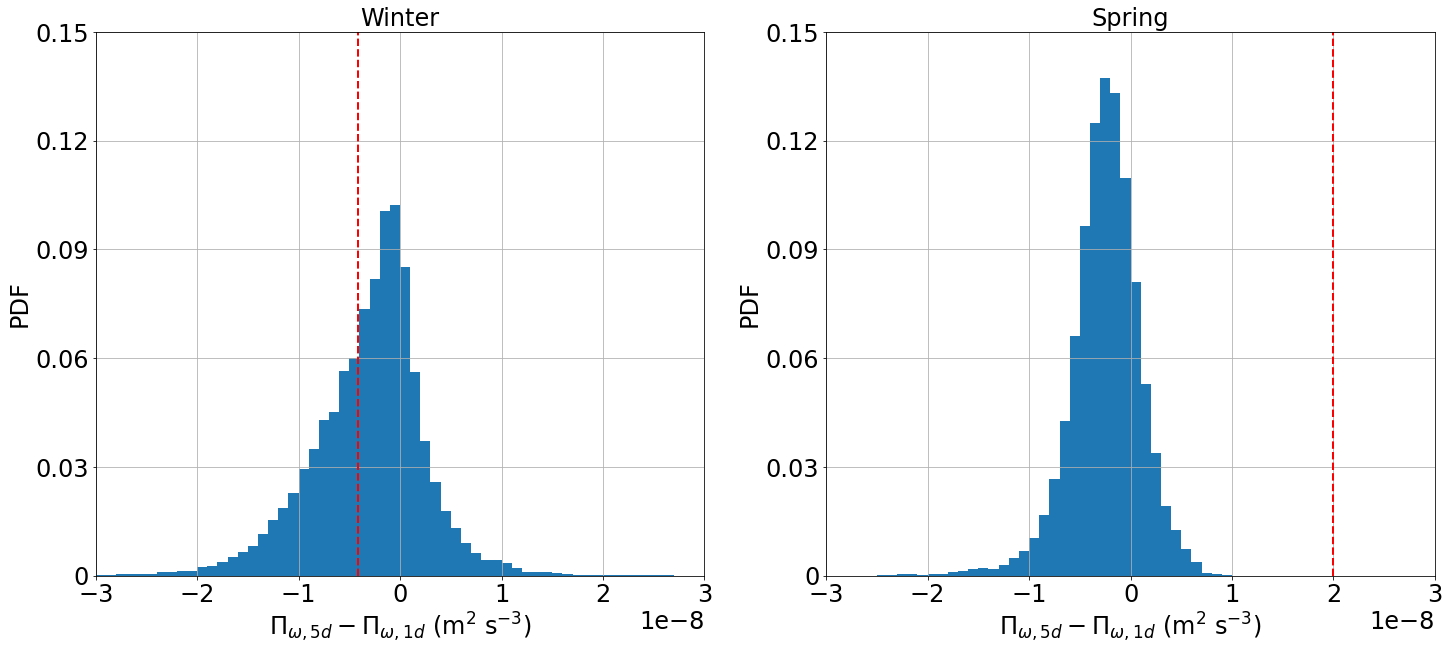

In [16]:
plt.rc('font', size=24) 
font_size=24

fig, ax = plt.subplots(figsize=(24,10))

ax = plt.subplot(121)
winter.plot.hist(bins=np.arange(-3e-8,3e-8,1e-9),density=True)
ax.grid()
ax.set_xlim([-3e-8,3e-8])
ax.set_ylim([0.,1.5*1e8])
ax.set_yticks([0,0.03*1e9,0.06*1e9,0.09*1e9,0.12*1e9,0.15*1e9])
ax.set_yticklabels(['0','0.03', '0.06', '0.09', '0.12', '0.15'])
#ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_title('Winter',fontsize=font_size)
ax.set_ylabel('PDF',fontsize=font_size)
#ax.set_xlabel('$\Pi_{\omega}$ (m$^2$ s$^{-3}$)',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.plot([-4.14e-9,-4.14e-9],[0.,1.5*1e8], 'r--', linewidth=2)  # S2

ax = plt.subplot(122)
spring.plot.hist(bins=np.arange(-3e-8,3e-8,1e-9),density=True)
ax.grid()
ax.set_xlim([-3e-8,3e-8])
ax.set_ylim([0.,1.5*1e8])
ax.set_yticks([0,0.03*1e9,0.06*1e9,0.09*1e9,0.12*1e9,0.15*1e9])
ax.set_yticklabels(['0','0.03', '0.06', '0.09', '0.12', '0.15'])
ax.set_ylabel('PDF',fontsize=font_size)
#ax.set_xlabel('$\Pi_{\omega}$ (m$^2$ s$^{-3}$)',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.plot([2e-8,2e-8],[0.,1.5*1e8], 'r--', linewidth=2)  # S2

plt.savefig('/home1/datahome/xyu/equinox_working/OSMOSIS/Diagnostics/Figures/Pi_pdf.png')

_______________________
# 3. Counts / percentages

In [17]:
# PI(winter)<0 and PI(spring)>0  ----> similar to the moorings
mooring_like = spring.where( (winter<0) & (spring>0))

# PI(winter)<0 and PI(spring)<0  ----> same to the model average
model_like = spring.where( (winter<0) & (spring<0))

In [18]:
# counts of PI(winter)<0 and PI(spring)>0
mooring_like.count(dim=['lat','lon'])

<xarray.DataArray 'PI_cg' ()>
array(3070)

In [19]:
# counts of PI(winter)<0 and PI(spring)<0
model_like.count(dim=['lat','lon'])

<xarray.DataArray 'PI_cg' ()>
array(21840)

In [20]:
# total counts (take spring as example)
spring.count(dim=['lat','lon'])

<xarray.DataArray 'PI_cg' ()>
array(34081)

In [21]:
3010/34081

0.08831900472403979

In [22]:
21761/34081

0.6385082597341627

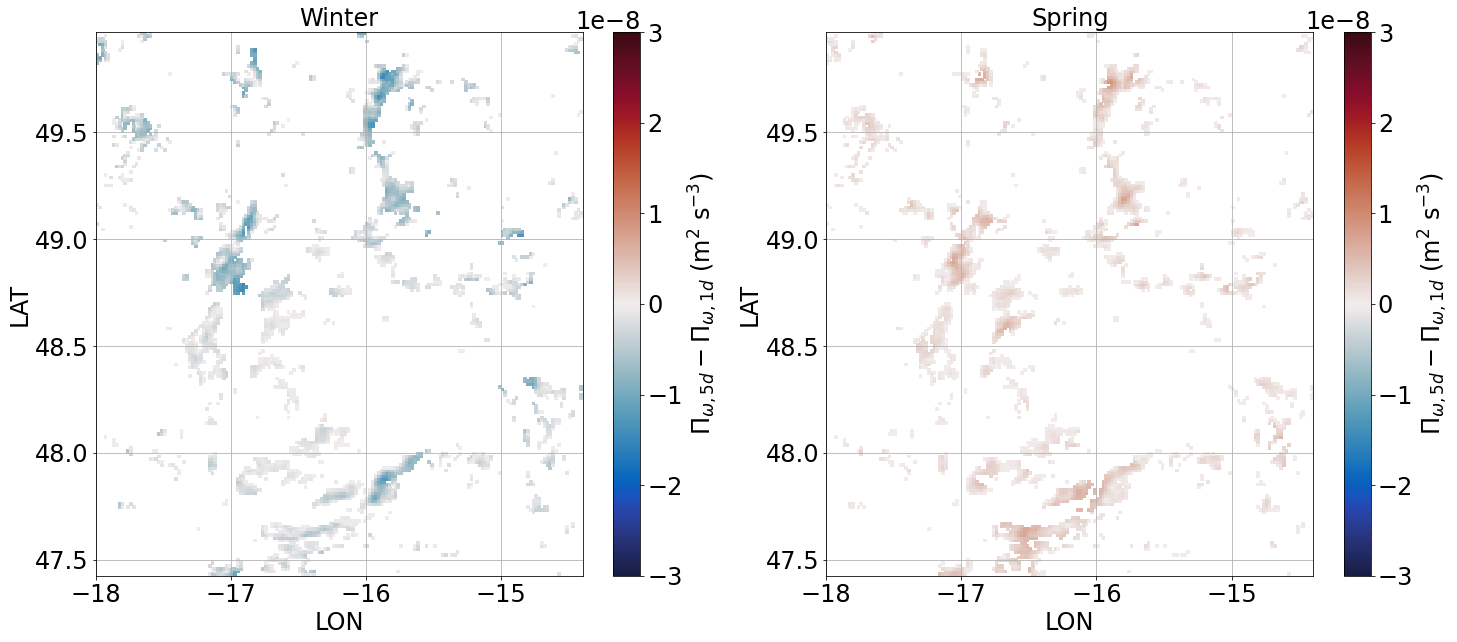

In [24]:
# mooring-like
# winter inverse cascade
# spring forward cascade

mooring_like_winter = winter.where( (winter<0) & (spring>0))
mooring_like_spring = spring.where( (winter<0) & (spring>0))

plt.rc('font', size=24) 
font_size=24

fig, ax = plt.subplots(figsize=(24,10))
ax = plt.subplot(121)
cax = mooring_like_winter.plot(x='lon', y='lat',cmap=cm.balance, vmin=-3e-8,vmax=3e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.set_title('Winter',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(122)
cax = mooring_like_spring.plot(x='lon', y='lat',cmap=cm.balance, vmin=-3e-8,vmax=3e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/OSMOSIS/Diagnostics/Figures/Pi_cg_mooring.png')

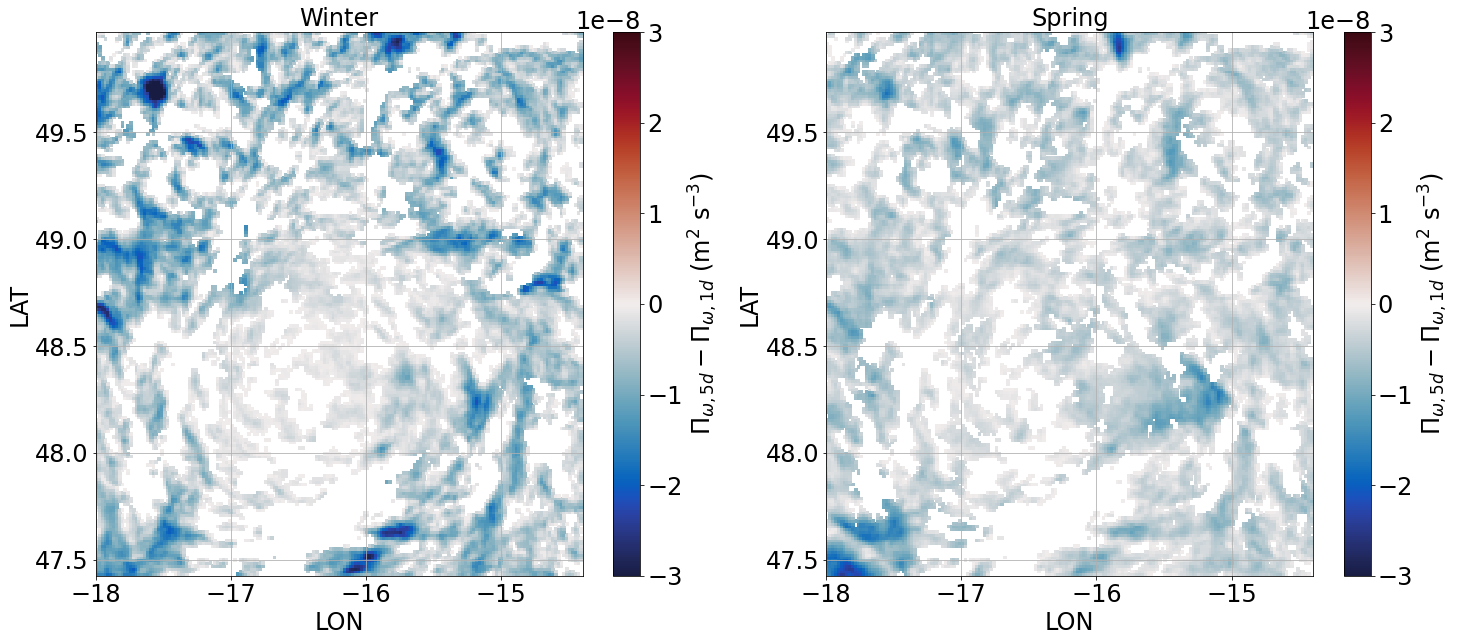

In [25]:
# winter inverse cascade
# spring inverse cascade

model_like_winter = winter.where( (winter<0) & (spring<0))
model_like_spring = spring.where( (winter<0) & (spring<0))

plt.rc('font', size=24) 
font_size=24

fig, ax = plt.subplots(figsize=(24,10))
ax = plt.subplot(121)
cax = model_like_winter.plot(x='lon', y='lat',cmap=cm.balance, vmin=-3e-8,vmax=3e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.set_title('Winter',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(122)
cax = model_like_spring.plot(x='lon', y='lat',cmap=cm.balance, vmin=-3e-8,vmax=3e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega, 5d} - \Pi_{\omega, 1d}$ (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/OSMOSIS/Diagnostics/Figures/Pi_cg_model.png')

_____________
# 3. w'b'

In [34]:
# w'b'
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/'
wb_prime_filter = xr.open_zarr(out_dir_zarr+'wb_prime_1day_filter.zarr')
wb_prime_filter

# mld
out_dir = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')
ds_MLD

ds = xr.merge([wb_prime_filter,ds_MLD])
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))
ds = ds.assign_coords(time=time_day) 
ds.persist()
ds

<xarray.Dataset>
Dimensions:          (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth            (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * time             (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Dimensions without coordinates: lat, lon
Data variables:
    wb_prime_filter  (time, depth) float32 dask.array<chunksize=(9415, 1), meta=np.ndarray>
    mld_filter       (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>

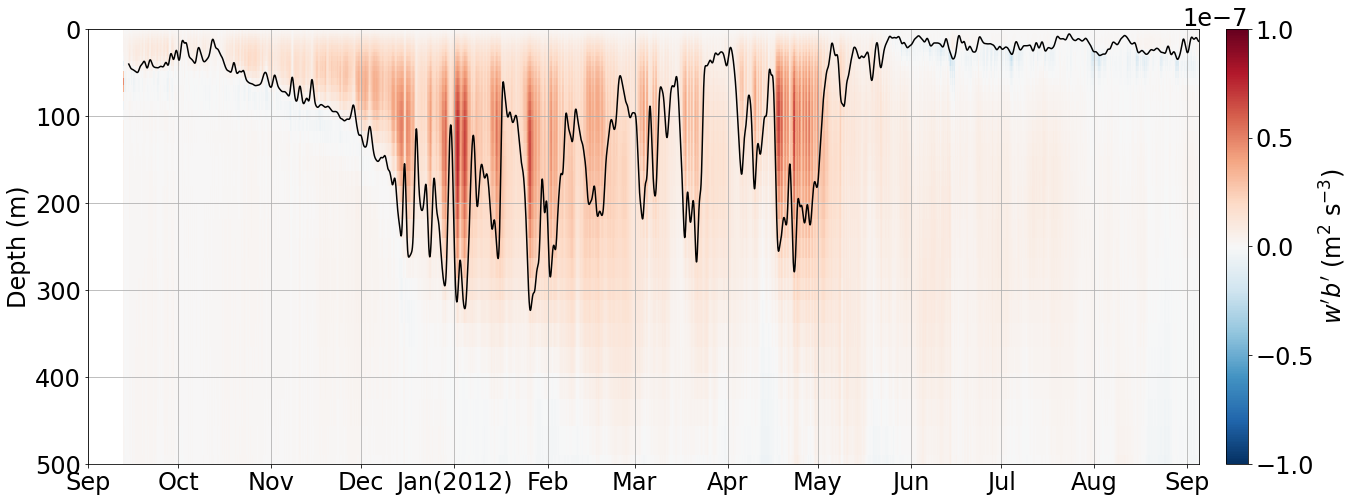

In [36]:
plt.rc('font', size=24) 
font_size=24

fig, ax = plt.subplots(figsize=(24,8))

ax = plt.subplot(111)
cax=ds.wb_prime_filter.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-1e-7, -0.5e-7, 0, 0.5e-7, 1e-7], pad=0.02)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)', fontsize=font_size)
ds.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan\n2012', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], ha='center')
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan(2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], ha='center')
plt.xticks(rotation=0)
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/OSMOSIS/Diagnostics/Figures/wb.png')

In [10]:
cluster.close()